In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#clustering
from scipy.spatial.distance import cdist,pdist
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-data/marketing_data.csv


In [2]:
data = pd.read_csv('/kaggle/input/marketing-data/marketing_data.csv')

**Data Cleansing**

In [3]:
todayy = pd.Timestamp('28/2/21')
data['Dt_Customer']= pd.to_datetime(data['Dt_Customer'])
data['Dt_Customer'] = (todayy - data['Dt_Customer']).dt.days

RFM is segmentation based on customer behavior.(Spending, cunsumption habbit, product/service usage, previously purchased product)

>- Recency (R): The last time cust. bought a product.
>- Frequency (F): Frequency of cust. make a purchase
>- Monetary Value(M): The total value of expenditure from cust(because there is no price on the dataset will be calculated from the summation of the purchased product without multiplying the product price)

Will be create 2 additional variables:

>- Variable __*Spending*__ Total of 6 Products that have been purchased.
>- Variable __*Transactions*__ Total of the number of times a customer buys a product.

**Workflow:**
    
1. First looking for R&F&M value, after obtaining the value of Recency, Frequency and Monetary we will search the number of clusters from each column RFM using elbow and silloutte method. 
2. Recheck the number of clusters if using Recency, Frequency and Monetary at once.
3. After getting the right number of clusters, rfm class will be created which contains the total of cluster score to get the right number of segmentation.


**Create 2 Variable**

In [5]:
data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
data['Transactions']=data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']
data=data[['ID','Spending','Transactions','Recency','Dt_Customer']]
data = data[data['Transactions'] > 1] # customers with repeated purchases, implying number of transactions must be at least 2
data = data[data['Spending'] > 0]

In [6]:
#statistical summary
print("Summary of the last 2 years spending")
print("Number of transactions: ", data['Transactions'].sum())
print("Total sales: ",data['Spending'].sum())
print("Number of customers:", data['ID'].nunique())

Summary of the last 2 years spending
Number of transactions:  28077
Total sales:  1354764
Number of customers: 2228


# *Recency*

In [7]:
recency = data[['ID','Recency']]
recency

,ID,Recency
0,1826,0
1,1,0
2,10476,0
3,1386,0
4,5371,0
...,...,...
2235,10142,99
2236,5263,99
2237,22,99
2238,528,99


# *Frequency*

In [8]:
frequency = data[['ID','Spending']]
frequency

,ID,Spending
0,1826,1190
1,1,577
2,10476,251
3,1386,11
4,5371,91
...,...,...
2235,10142,689
2236,5263,55
2237,22,309
2238,528,1383


# *Monatary*

In [9]:
monetary = data[['ID','Transactions']]
monetary

,ID,Transactions
0,1826,14
1,1,17
2,10476,10
3,1386,3
4,5371,6
...,...,...
2235,10142,18
2236,5263,4
2237,22,12
2238,528,19


In [10]:
temp = recency.merge(frequency,on='ID')
RFM_Segmentation  = temp.merge(monetary,on='ID')
RFM_Segmentation.columns = ['ID','Recency','Frequency','Monetary']
RFM_Segmentation

,ID,Recency,Frequency,Monetary
0,1826,0,1190,14
1,1,0,577,17
2,10476,0,251,10
3,1386,0,11,3
4,5371,0,91,6
...,...,...,...,...
2223,10142,99,689,18
2224,5263,99,55,4
2225,22,99,309,12
2226,528,99,1383,19


# Find Number of Clusters from Recency,Frequency,Monetary

****Recency Cluster****

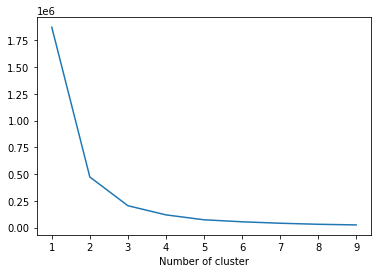

In [11]:
#Elbow Method
sse={}
tx_recency = RFM_Segmentation[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Text(0, 0.5, 'silloutte score')

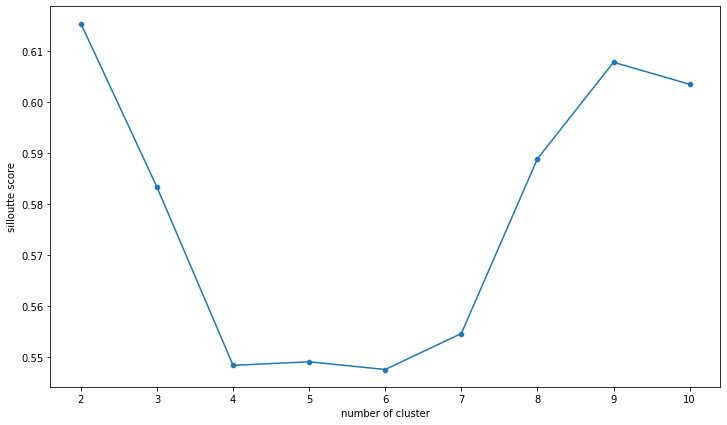

In [12]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_recency)

labels=kmeans.labels_
silhouette_score(tx_recency,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_recency)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_recency,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

Based on Elbow method and sillhoutte method, Recency has 2 clusters

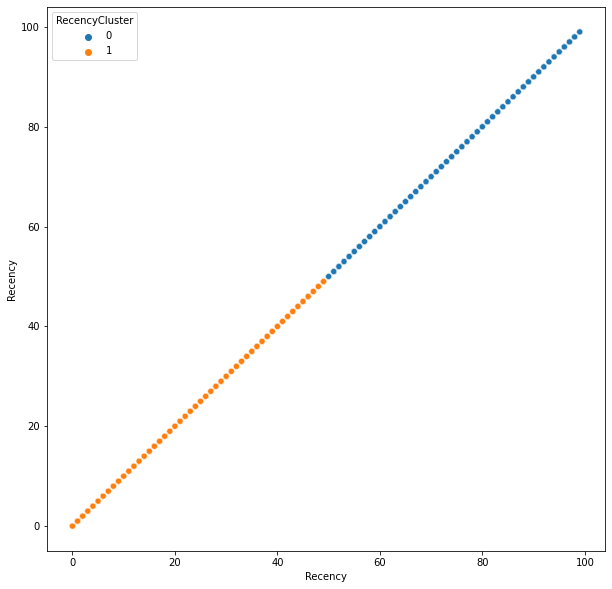

In [16]:
#make column for Recency Cluster
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(RFM_Segmentation[['Recency']])
RFM_Segmentation['RecencyCluster'] = kmeans.labels_

#visualization Recency cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Recency', y ='Recency',data=RFM_Segmentation,hue='RecencyCluster')
plt.show()

**Frequency Clusters**

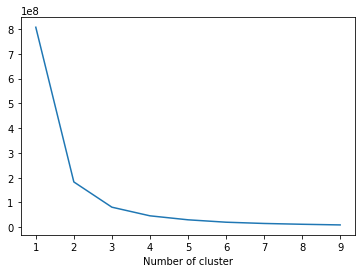

In [19]:
#Elbow Method
sse={}
tx_Frequency = RFM_Segmentation[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_Frequency)
    tx_Frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


Text(0, 0.5, 'silloutte score')

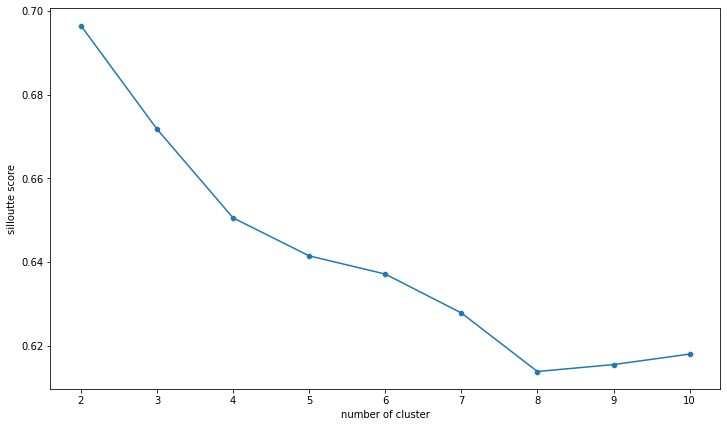

In [20]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_Frequency)

labels=kmeans.labels_
silhouette_score(tx_Frequency,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_Frequency)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_Frequency,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

Based on Elbow method and sillhoutte method, Recency has 2 clusters

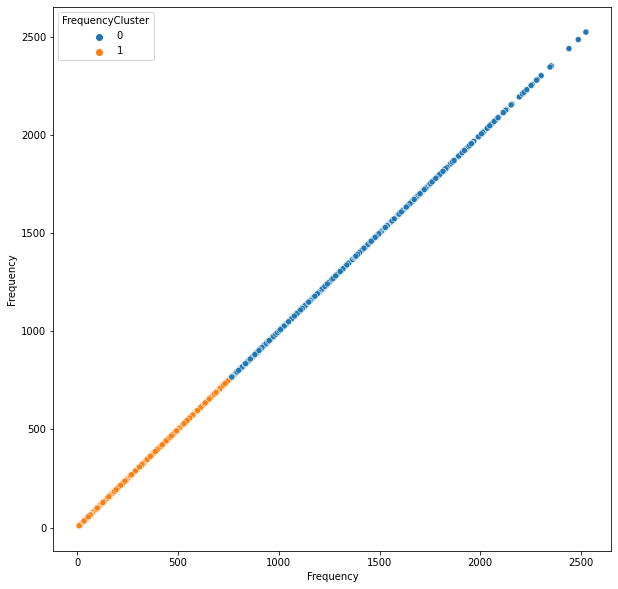

In [21]:
#make column Frequency Cluster
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(RFM_Segmentation[['Frequency']])
RFM_Segmentation['FrequencyCluster'] = kmeans.labels_

#visualization Frequency cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Frequency', y ='Frequency',data=RFM_Segmentation,hue='FrequencyCluster')
plt.show()


In [22]:
#for reverse cluster value, cause the higher frequency is better
RFM_Segmentation['FrequencyCluster']=np.where(RFM_Segmentation['FrequencyCluster']==1,0,1)

****Monetary Cluster****

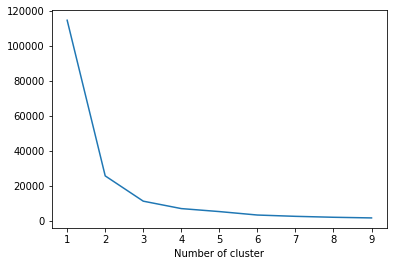

In [23]:
#Elbow Method
sse={}
tx_Monetary = RFM_Segmentation[['Monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=0).fit(tx_Monetary)
    tx_Monetary["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Text(0, 0.5, 'silloutte score')

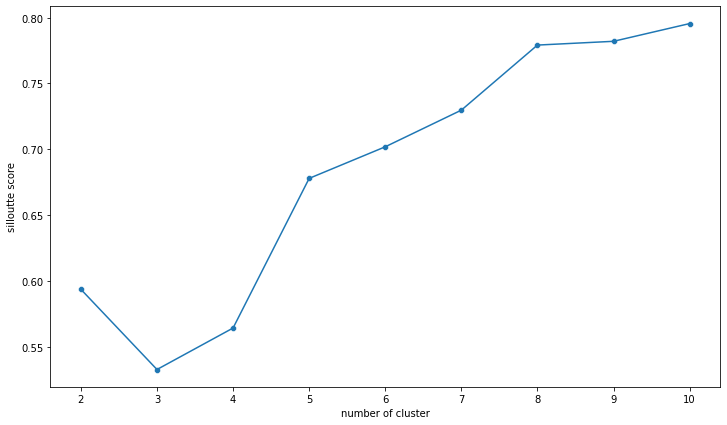

In [24]:
#silhouette
kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(tx_Monetary)

labels=kmeans.labels_
silhouette_score(tx_Monetary,labels,metric='euclidean')

s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(tx_Monetary)
    labels=kmeans.labels_
    s_score.append(silhouette_score(tx_Monetary,labels,metric='euclidean'))
    
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')


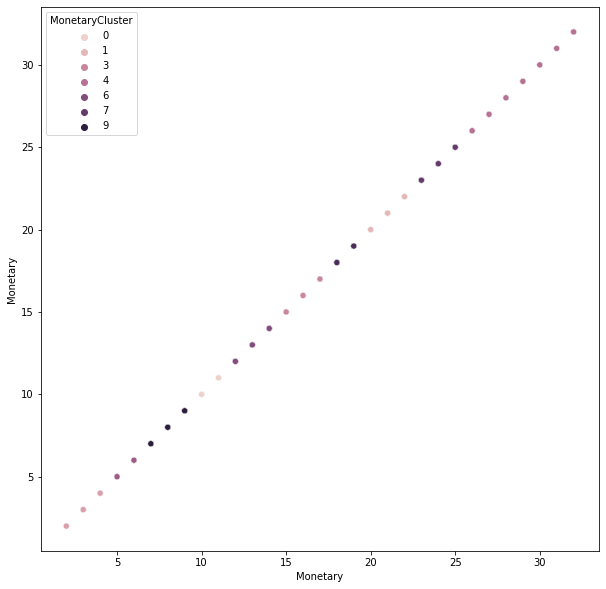

In [25]:
#make column for Monetary Cluster
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(RFM_Segmentation[['Monetary']])
RFM_Segmentation['MonetaryCluster'] = kmeans.labels_

#visualization Monetary cluster
plt.figure(figsize=(10,10))

sns.scatterplot(x='Monetary', y ='Monetary',data=RFM_Segmentation,hue='MonetaryCluster')
plt.show()


*Based on elbow method has 2 clusters while based on sillhoutte score monetary has 10 clusters(and the number of clusters will continue to grow if the range n_cluster enlarged) this indicates* **the absence of clusters in Monetary** *which could be due to the absence of price data from each product.*

In [26]:
RFM_Segmentation

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,1826,0,1190,14,1,1,6
1,1,0,577,17,1,0,3
2,10476,0,251,10,1,0,0
3,1386,0,11,3,1,0,2
4,5371,0,91,6,1,0,5
...,...,...,...,...,...,...,...
2223,10142,99,689,18,0,0,8
2224,5263,99,55,4,0,0,2
2225,22,99,309,12,0,0,6
2226,528,99,1383,19,0,1,8


# Check Number of Cluster with other method

In [28]:
X=RFM_Segmentation[['Recency','Frequency','Monetary']]

In [30]:
X

,Recency,Frequency,Monetary
0,0,1190,14
1,0,577,17
2,0,251,10
3,0,11,3
4,0,91,6
...,...,...,...
2223,99,689,18
2224,99,55,4
2225,99,309,12
2226,99,1383,19


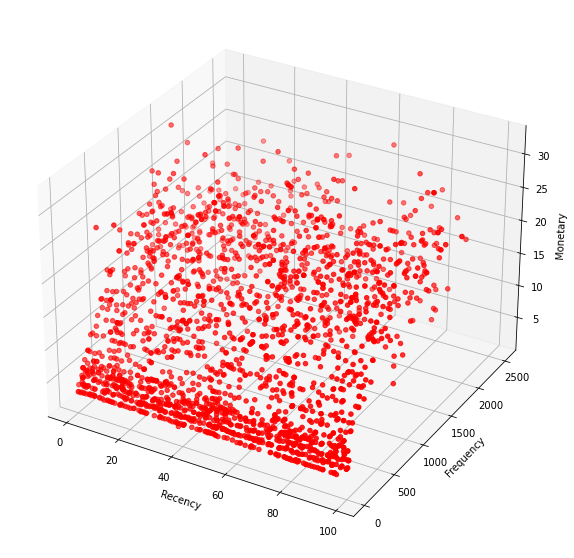

In [31]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(111,projection='3d')

x=X['Recency']
y=X['Frequency']
z=X['Monetary']
ax.scatter(x,y,z,c='r',marker='o')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

Text(0, 0.5, 'average within sum square')

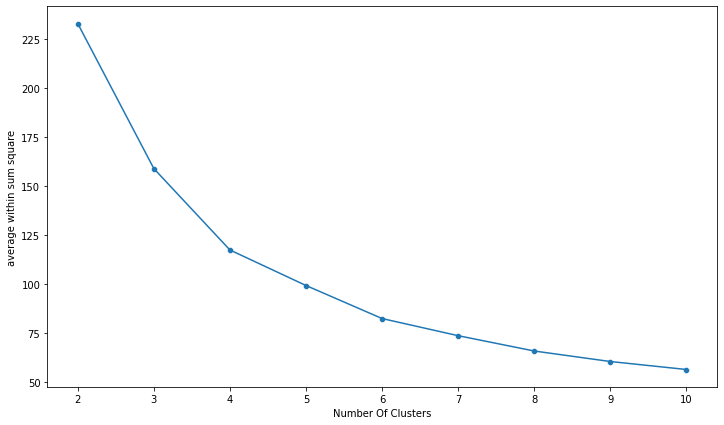

In [32]:
#elbow method
#clustering variation
number_of_cluster = range(2,11)
clusterings=[KMeans(n_clusters=k,random_state=0).fit(X) for k in number_of_cluster]
centroids= [k.cluster_centers_ for k in clusterings]

#within sum square, utk cari jarak 
D_k=[cdist(X,cent,'euclidean') for cent in centroids]
cIdx=[np.argmin(D,axis=1) for D in D_k]
dist=[np.min(D,axis=1)for D in D_k]
avg_withinSS=[sum(d)/X.shape[0] for d in dist]

#visualisasi
plt.figure(figsize=(12,7))
sns.lineplot(number_of_cluster,avg_withinSS)
sns.scatterplot(number_of_cluster,avg_withinSS)

plt.xticks(number_of_cluster)

plt.xlabel('Number Of Clusters')
plt.ylabel('average within sum square')

based on elbow method there ae 3 or 4 clusters

Text(0, 0.5, 'silloutte score')

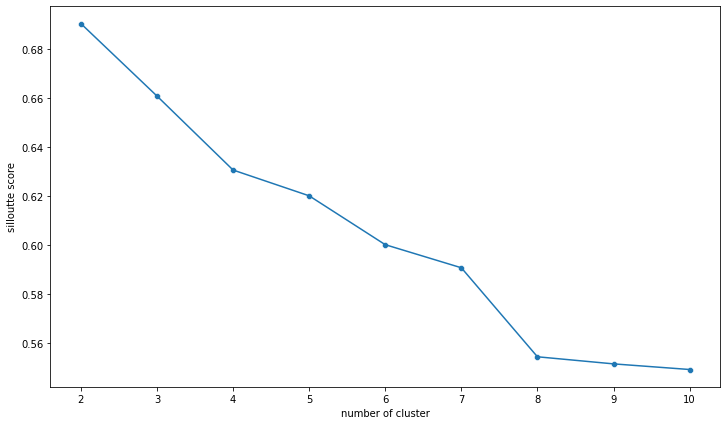

In [33]:
#Sillhoutte
s_score=[]

number_of_cluster = range(2,11)

for i in number_of_cluster:
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(X)
    labels=kmeans.labels_
    s_score.append(silhouette_score(X,labels,metric='euclidean'))
    
#viasulisasi
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster,s_score)
sns.scatterplot(number_of_cluster,s_score)

plt.xticks(number_of_cluster)
plt.xlabel('number of cluster')
plt.ylabel('silloutte score')

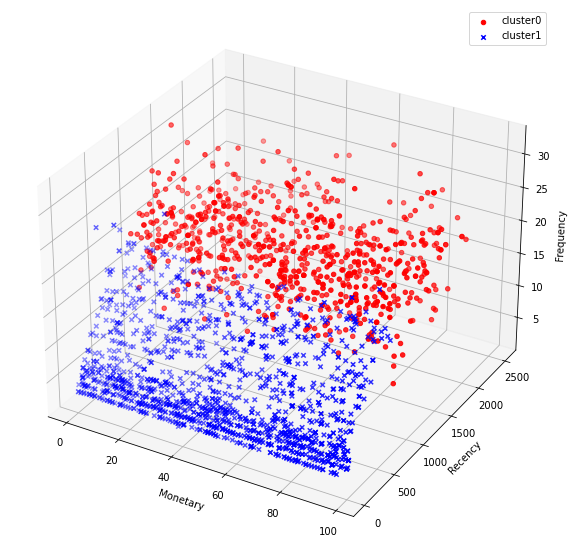

In [34]:
#final result we decide to use 2 cluster (based on silloutte score)

kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(X)
RFM_Segmentation['cluster']=kmeans.labels_

#visualisasi
fig=plt.figure(figsize=(10,10))
ax= fig.add_subplot(111,projection='3d')

ax.scatter(X['Recency'][RFM_Segmentation['cluster']==0],X['Frequency'][RFM_Segmentation['cluster']==0],X['Monetary'][RFM_Segmentation['cluster']==0], c='r', marker='o')
ax.scatter(X['Recency'][RFM_Segmentation['cluster']==1],X['Frequency'][RFM_Segmentation['cluster']==1],X['Monetary'][RFM_Segmentation['cluster']==1], c='b', marker='x')


ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_xlabel('Monetary')

plt.legend(('cluster0','cluster1'))

plt.show()

SUMMARY

after we compared 2 different methods and the result is same, there are 2 clusters. so the cluster will be selected is 2. and Segmentation will be based on rf(Recency Frequency) Score value, because Monetary has no cluster and is only used for aggregate

# **Make RF Score**

In [37]:
RFM_Segmentation['RF_Score'] = RFM_Segmentation['RecencyCluster'] + RFM_Segmentation['FrequencyCluster']
RFM_Segmentation.groupby('RF_Score')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
RF_Score,,,
0,74.567919,211.819364,8.507225
1,42.070130,609.439827,12.581818
2,24.081365,1323.574803,20.099738


In [38]:
#Clustering naming based on unique RFM values
def rfm_label(df):
    if df['RF_Score'] == 2:
        return 'Priority'
    elif ((df['RF_Score'] == 1)):
        return 'Loyal'
    else:
        return 'Need Attention'

In [39]:
RFM_Segmentation['RFM_Label'] = RFM_Segmentation.apply(rfm_label, axis=1)
RFM_Segmentation

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,cluster,RF_Score,RFM_Label
0,1826,0,1190,14,1,1,6,0,2,Priority
1,1,0,577,17,1,0,3,1,1,Loyal
2,10476,0,251,10,1,0,0,1,1,Loyal
3,1386,0,11,3,1,0,2,1,1,Loyal
4,5371,0,91,6,1,0,5,1,1,Loyal
...,...,...,...,...,...,...,...,...,...,...
2223,10142,99,689,18,0,0,8,1,0,Need Attention
2224,5263,99,55,4,0,0,2,1,0,Need Attention
2225,22,99,309,12,0,0,6,1,0,Need Attention
2226,528,99,1383,19,0,1,8,0,1,Loyal


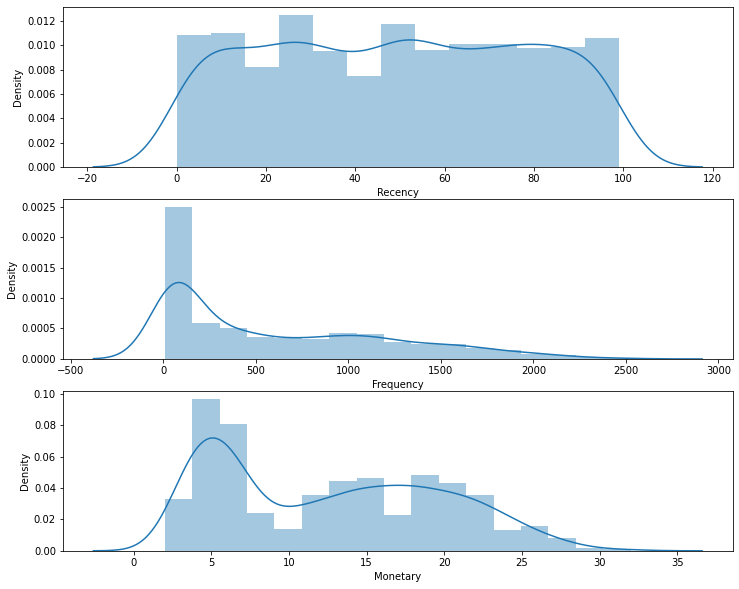

In [40]:
#plot distribution
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM_Segmentation['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM_Segmentation['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM_Segmentation['Monetary'])
# Show the plot
plt.show()

*Recency*
norm distribution Means that the average customer does have recency with an even frequency

*Frequency*
leftSkewed Means uneven distribution, more customers have low frequency than high frequency value

*Monetary*
leftSkewed Means many customers who shop for small amounts.

<AxesSubplot:xlabel='count', ylabel='RFM_Label'>

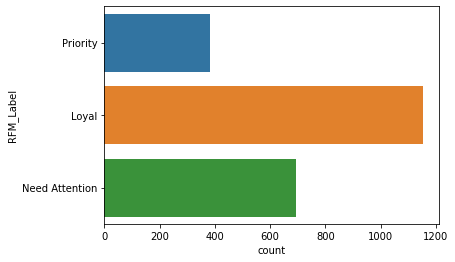

In [41]:
sns.countplot(y='RFM_Label',data=RFM_Segmentation)

In [42]:
#analyss persegment
# Calculate average values for each RFM segment, and return a size of each segment 
RFM_interpret = RFM_Segmentation.groupby('RFM_Label').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
# Print the aggregated dataset
RFM_interpret

Recency Frequency Monetary      
                  mean      mean     mean count
RFM_Label                                      
Loyal             42.1     609.4     12.6  1155
Need Attention    74.6     211.8      8.5   692
Priority          24.1    1323.6     20.1   381

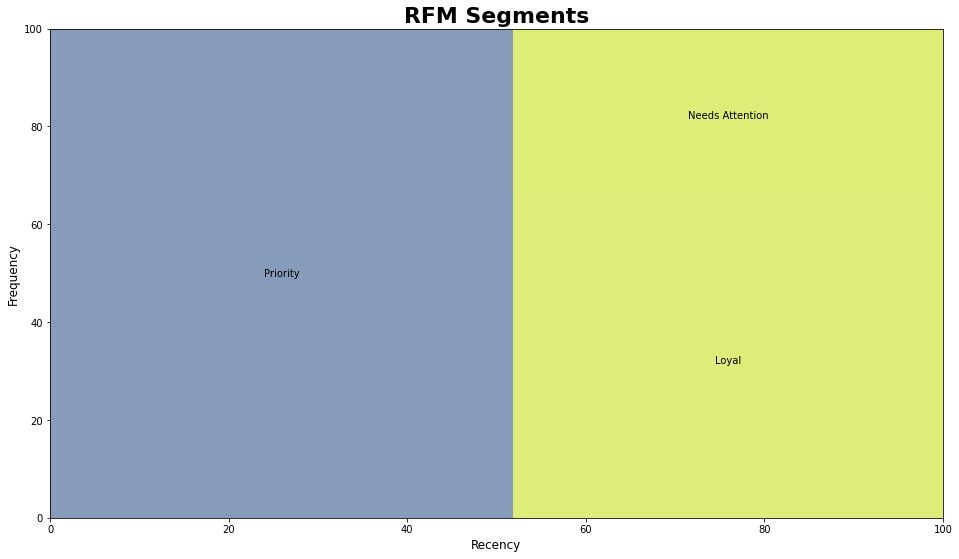

In [43]:
#segment vizual R and F
#monetary just for agg
import squarify
RFM_interpret.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=RFM_interpret['Count'], 
              label=['Priority', 'Loyal','Needs Attention'], alpha=.6 )
plt.title("RFM Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.axis('on')
plt.show()

**INTERPRETATION**

*Customers is for customers who are already members of the company*

**Priority**
>Cust the most frequent shopping (low recency), most often keep intouch with the company through the purchase of products from several market places as well as the most spending money to the company.

>advice: For Priority segmentation treat such as giving more rewards, giving info and testers on each new product, because usually they help promote to the nearest person. As well as with more rewards for priority segments will attract customers who are under Priority to increase membership / segment


**Loyal**
>Cust who have not long shopped our products, and the value has a sufficient fre quency and monetary value. This customer is under the Priority segment, usually they shop only if there is a discount or urgent need. we can see that loyal dominates the segmentation.

>advice : for loyal segmentation is better cust given a small discount but in frequency often against some products in turn in order to increase frequency and monetary.

**Needs Attention**
>Cust who have not bought our product for a long time. This segment should be more considered because this segment has a high probability to break up members / not extend the member company, which can result in decreased sales in the long run (because branding is weak with few customers)

>Advice: Ask for advice to this segment about what the shortcomings of the product sold or in terms of service. Because usually cust turned because there is no match with the product / service, As well as provide a special Discount for this segment.

    **SUMMARY SUGGESTION**
This segmentation is made to know the right treatment to each customer with the aim of maintaining Customer membership, after knowing the segment of each customer then the company can hold membership levels based on existing Segments and provide different rewards. And there can be challenges to increase membership, so that customers compete with each other to shop.


